## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn4.ipynb의 코드에서 좀 더 dqn3.ipynb와 섞은 버전

In [1]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [3]:
env = gymnasium.make('CartPole-v1')
hidden_size = 128
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)
q = DQN(*env.observation_space.shape, env.action_space.n)
target_q = DQN(*env.observation_space.shape, env.action_space.n)
target_q.load_state_dict(q.state_dict())
# target_q = copy.deepcopy(q).requires_grad_(False)

<All keys matched successfully>

In [4]:
lr = 1e-4
discount = 0.99
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(q.parameters(), lr=lr, amsgrad=True)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [5]:
def optimize_model():
    if len(replay_buffer) < batch_size:
        return
    batch = replay_buffer.sample(batch_size)
    non_final_next_states = batch.next_state[batch.terminated]
    state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(0)).squeeze()
    next_state_values = torch.zeros_like(state_action_values, device='cpu')
    with torch.no_grad():
        target_q(non_final_next_states)
        next_state_values[batch.terminated] = target_q(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * discount) + batch.reward
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(q.parameters(), 100)
    optimizer.step()

In [6]:
steps = []
action_count = 0
device = 'cpu'
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Store the transition in memory
        replay_buffer.append(state, action, reward, next_state, not terminated)
    
        optimize_model()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict() 
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    steps.append(step)

    if (i + 1) % 100 == 0:
        print(np.mean(steps[-100:]))

  0%|          | 0/600 [00:00<?, ?it/s]/home/seokj/workspace/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
 17%|█▋        | 104/600 [00:05<00:20, 24.51it/s]

14.03


 34%|███▎      | 201/600 [00:10<00:25, 15.67it/s]

11.43


 50%|█████     | 301/600 [00:16<00:18, 16.59it/s]

11.76


 67%|██████▋   | 402/600 [00:22<00:11, 16.55it/s]

13.25


 84%|████████▍ | 503/600 [00:28<00:05, 18.40it/s]

13.45


100%|██████████| 600/600 [00:36<00:00, 16.54it/s]

14.94


In [7]:
len(replay_buffer)

8486

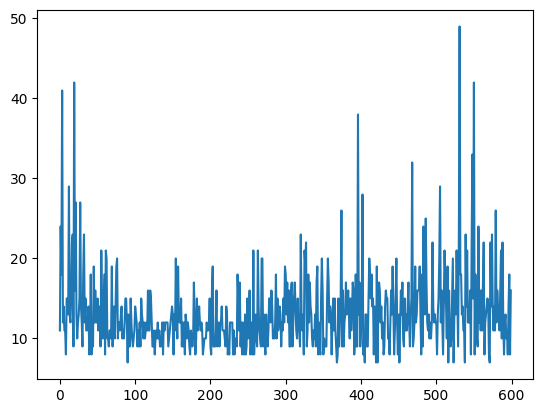

In [8]:
import matplotlib.pyplot as plt
plt.plot(steps)

In [9]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[12.0, 18.0, 15.0, 12.0, 13.0, 14.0, 13.0, 17.0, 14.0, 13.0]

In [10]:
env.close()

In [11]:
env = gymnasium.make('CartPole-v1')